## LSTM based model
Initially single LSTM based model was created, finally 7 LSTM models were created with random dense layers and dropouts and averaged with 6 xgb models with 
random hyperparameters. Model structure is shown below.

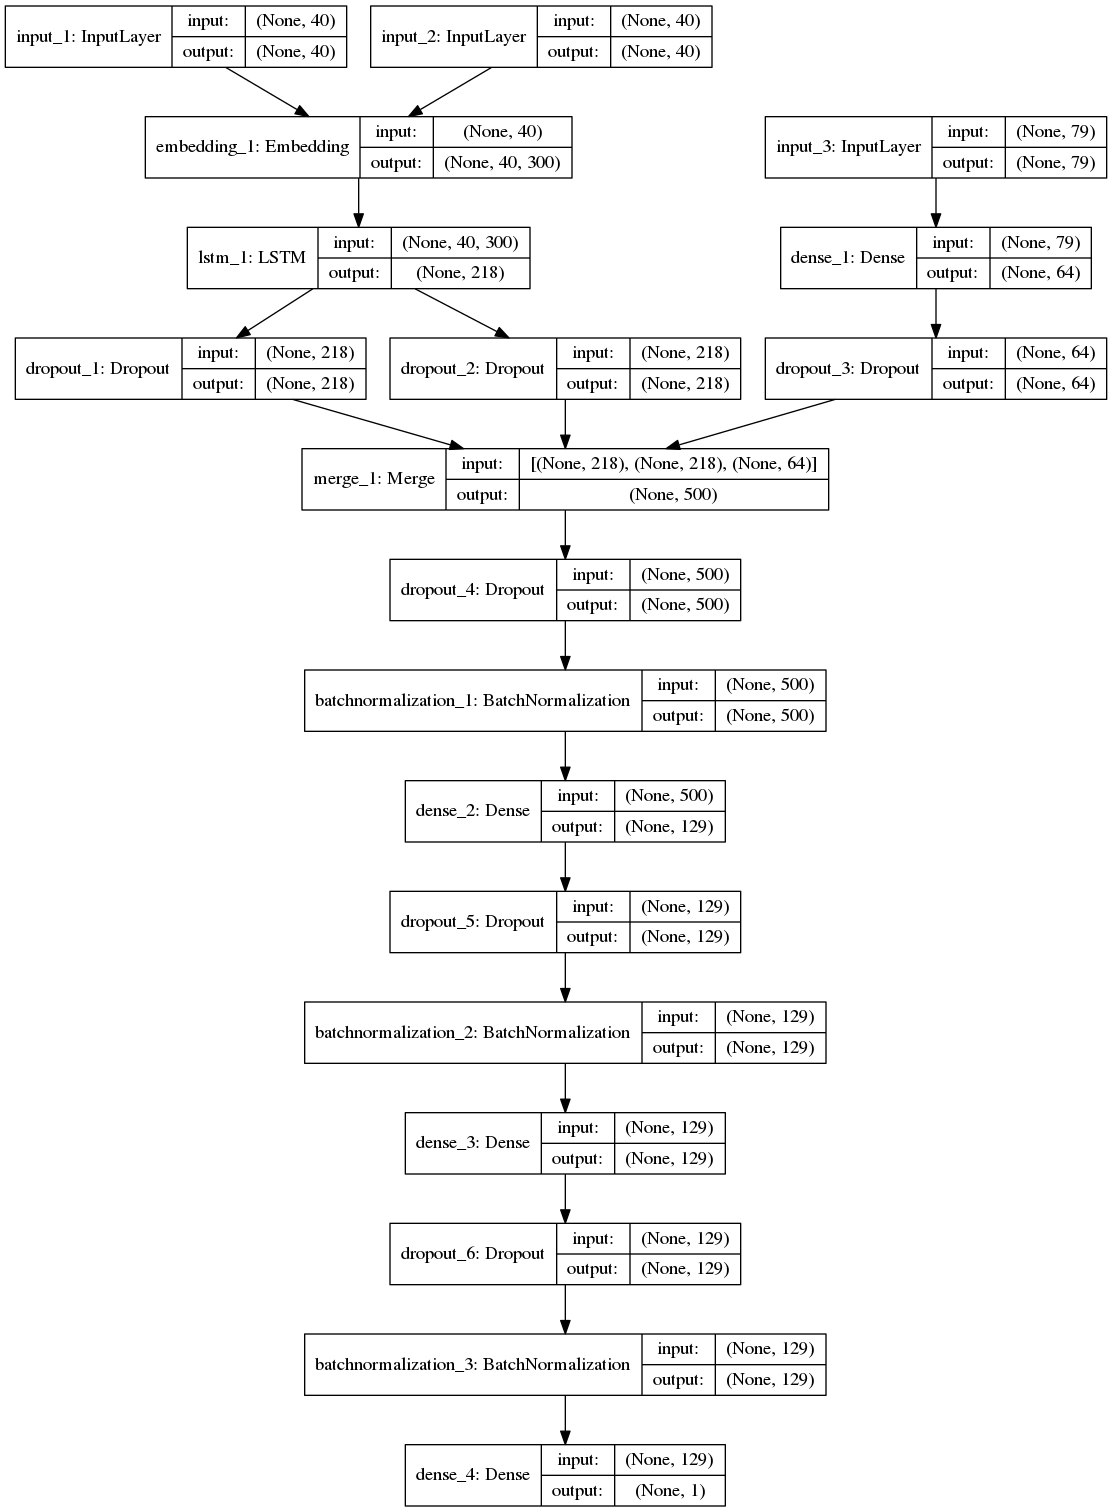

In [4]:
from IPython.display import Image
Image("model.png")

## Importing Packages

In [5]:
# Importing packages
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from string import punctuation
from collections import defaultdict

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function
# import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, rate_drop_dense)
from keras_tqdm import TQDMNotebookCallback
import gc

In [6]:
# Directory Setup
BASE_DIR = ''
GLOVE_DIR = BASE_DIR
TRAIN_DATA_FILE = BASE_DIR + 'train.csv'
TEST_DATA_FILE = BASE_DIR + 'test.csv'
MAX_SEQUENCE_LENGTH = 40
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
EMBEDDING_FILE = BASE_DIR + 'glove.840B.300d.txtt'

## Indexing Glove

In [ ]:
print('Indexing word vectors.')
embeddings_index = {}
f = codecs.open(os.path.join(GLOVE_DIR, 'glove.840B.300d.txt'), encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

## Text Processing

In [ ]:
# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "i am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " america ", text)
    text = re.sub(r" USA ", " america ", text)
    text = re.sub(r" u s ", " america ", text)
    text = re.sub(r" uk ", " england ", text)
    text = re.sub(r" UK ", " england ", text)
    text = re.sub(r"india", "india", text)
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "america", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r" J K ", " JK ", text)
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [ ]:
# preprocessing
texts_1 = [] 
texts_2 = []
labels = []
with codecs.open(TRAIN_DATA_FILE.encode('utf-8').strip()) as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        texts_1.append(text_to_wordlist(values[3]))
        texts_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print ('train completed')
test_texts_1 = []
test_texts_2 = []
test_ids = []
with codecs.open(TEST_DATA_FILE.encode('utf-8').strip()) as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_texts_1.append(text_to_wordlist(values[1]))
        test_texts_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])
print ('test completed')

In [ ]:
labels = np.array(labels)
labels.shape

## Tokenize

In [ ]:
# tokenize
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

In [ ]:
len(sequences_1[0]), texts_1[0], len(texts_1)

In [ ]:
texts_1[0], sequences_1[0]

In [ ]:
word_index = tokenizer.word_index

In [ ]:
# Unique tokens found
len(word_index)

In [ ]:
data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
# print('Shape of data tensor:', data_1.shape)
# print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)

## Leaky Features

In [ ]:
# new feaatures
trn = pd.read_csv('X_train.csv')
tst = pd.read_csv('X_test.csv')
trn = trn.fillna(value=0)
tst = tst.fillna(value=0)
trn.shape, tst.shape

In [ ]:
trn = trn.replace([np.inf, -np.inf], 0)
tst = tst.replace([np.inf, -np.inf], 0)

In [ ]:
leaks = trn[trn.columns.values]
test_leaks = tst[tst.columns.values]
ss = StandardScaler()
ss.fit(np.vstack((leaks, test_leaks)))
leaks = ss.transform(leaks)
test_leaks = ss.transform(test_leaks)

## Embeddings

In [ ]:
# embeddings
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = normal(scale=0.6, size=(EMBEDDING_DIM,))
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

## Validation Data

In [23]:
np.random.seed(1234)
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
leaks_train = np.vstack((leaks[idx_train], leaks[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
leaks_val = np.vstack((leaks[idx_val], leaks[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

## Save and Load Data

In [26]:
# save data
save_array('data_1.bc', data_1)
save_array('data_2.bc', data_2)
save_array('test_data_1.bc', test_data_1)
save_array('test_data_2.bc', test_data_2)
save_array('leaks.bc', leaks)
save_array('test_leaks.bc', test_leaks)
save_array('embedding_matrix.bc', embedding_matrix)
save_array('labels.bc', labels)

In [27]:
# save lstm data
save_array('data_1_train.bc', data_1_train)
save_array('data_2_train.bc', data_2_train)
save_array('labels_train.bc', labels_train)

save_array('data_1_val.bc', data_1_val)
save_array('data_2_val.bc', data_2_val)
save_array('labels_val.bc', labels_val)

save_array('leaks_train.bc', leaks_train)
save_array('leaks_val.bc', leaks_val)

save_array('test_leaks.bc', test_leaks)

save_array('oof_train.bc', oof_train)
save_array('oof_val.bc', oof_val)
save_array('oof_tst.bc', oof_tst)

In [8]:
# load lstm data
data_1_train = load_array('data_1_train.bc')
data_2_train = load_array('data_2_train.bc')

data_1_val = load_array('data_1_val.bc')
data_2_val = load_array('data_2_val.bc')



labels_train = load_array('labels_train.bc')
labels_val = load_array('labels_val.bc')

leaks_train = load_array('leaks_train.bc')
leaks_val = load_array('leaks_val.bc')
test_leaks = load_array('test_leaks.bc')

oof_train = load_array('oof_train.bc')
oof_val = load_array('oof_val.bc')
oof_tst = load_array('oof_tst.bc')

In [9]:
# load data
data_1 = load_array('data_1.bc')
data_2 = load_array('data_2.bc')

test_data_1 = load_array('test_data_1.bc')
test_data_2 = load_array('test_data_2.bc')
leaks = load_array('leaks.bc')
test_leaks = load_array('test_leaks.bc')
labels = load_array('labels.bc')
embedding_matrix = load_array('embedding_matrix.bc')

##  Single LSTM Training

In [10]:
test_data_1.shape, test_data_2.shape,data_1_train.shape, data_2_train.shape, leaks_train.shape

((2345796, 40), (2345796, 40), (727722, 40), (727722, 40), (727722, 44))

In [ ]:
embedding_layer = Embedding(120336,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                           dropout=0.2)

In [ ]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [ ]:
num_lstm, num_dense, rate_drop_dense, rate_drop_lstm

In [ ]:
act = 'relu'
num_lstm=218
num_dense = 129
rate_drop_lstm = .31 
rate_drop_dense =.228
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

In [ ]:
#model structure
lstm_layer = LSTM(num_lstm, dropout_W=rate_drop_lstm, dropout_U=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)
x1 = Dropout(.2)(x1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)
y1 = Dropout(.2)(y1)

leaks_input = Input(shape=(leaks_train.shape[1],))
leaks_dense = Dense(int(num_dense/2), activation=act)(leaks_input)
leaks_dense = Dropout(.3)(leaks_dense)

merged = merge([x1, y1, leaks_dense],'concat')
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)


preds = Dense(1, activation='sigmoid')(merged)

In [ ]:
#complex code
lstm_layer = LSTM(num_lstm, dropout_W=rate_drop_lstm, dropout_U=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = LSTM(256, dropout_U=0.2, dropout_W=0.2, return_sequences=True)(embedded_sequences_1)
x1 = Dropout(.2)(x1)
x1 = LSTM(128, dropout_U=0.2, dropout_W=0.2)(x1)
x1 = Dropout(.2)(x1)


sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = LSTM(256, dropout_U=0.2, dropout_W=0.2, return_sequences=True)(embedded_sequences_2)
y1 = Dropout(.2)(y1)
y1 = LSTM(128, dropout_U=0.2, dropout_W=0.2)(y1)
y1 = Dropout(.2)(y1)

leaks_input = Input(shape=(leaks_train.shape[1],))
leaks_dense = Dense(int(num_dense/2), activation=act)(leaks_input)
leaks_dense = Dropout(.3)(leaks_dense)

merged = merge([x1, y1, leaks_dense],'concat')
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

In [ ]:
from IPython.display import Image, display, SVG
from keras.utils.visualize_util import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

# Save the model as png file
from keras.utils.visualize_util import plot
plot(model, to_file='model.png', show_shapes=True)

In [ ]:
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None
weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344 

In [ ]:
model = Model([sequence_1_input, sequence_2_input, leaks_input], preds)
model.compile(loss='binary_crossentropy',metrics=['acc'], optimizer='nadam')
#model.summary()
STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, rate_drop_dense)

print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '_best_1' + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [ ]:
class_weight, weight_val

In [ ]:
hist = model.fit([data_1_train, data_2_train, leaks_train], labels_train,
        validation_data=([data_1_val, data_2_val, leaks_val], labels_val, weight_val), 
        nb_epoch=200, batch_size=2048, shuffle=True, verbose=2,
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

In [ ]:
model.load_weights('lstm_218_129_0.31_0.23_best_1.h5')

In [ ]:
model.evaluate([data_1_val, data_2_val, leaks_val], labels_val, batch_size=4000, verbose=0, sample_weight=weight_val)

## 10  LSTM final solution

In [5]:
embedding_layer = Embedding(120336,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                           dropout=0.2)
act = 'relu'

In [6]:
test = pd.read_csv('test.csv')
test_ids = test.test_id
submission = pd.DataFrame({'test_id':test_ids})
# Only first 44 features were used otherwise it resulted in overfitting
leaks = leaks[:,0:44]
test_leaks = test_leaks[:,0:44]

In [7]:
submission = pd.read_csv('final.csv')
leaks.shape, test_leaks.shape

((404290, 44), (2345796, 44))

Only two models can be trained before GPU's VRAM runs out of memory, had to restart the kernel every time. 

In [8]:
# first model    

i=5
np.random.seed(i)
print ('fold = ' + str(i))
print ('--> Initializing')
#initialize with random values every time with different seed
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
lstm_drp = 0.15 + np.random.rand() * 0.25
leak_drp = 0.15 + np.random.rand() * 0.25
#----------------------------------------------------------------------------------
#model structure
lstm_layer = LSTM(num_lstm, dropout_W=rate_drop_lstm, dropout_U=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)
x1 = Dropout(lstm_drp)(x1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)
y1 = Dropout(lstm_drp)(y1)

leaks_input = Input(shape=(leaks_train.shape[1],))
leaks_dense = Dense(int(num_dense/2), activation=act)(leaks_input)
leaks_dense = Dropout(leak_drp)(leaks_dense)

merged = merge([x1, y1, leaks_dense],'concat')
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)
#----------------------------------------------------------------------------------

#handling the class imbalance
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None
weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344 
print ('--> Model Created')
#----------------------------------------------------------------------------------
model = Model([sequence_1_input, sequence_2_input, leaks_input], preds)
model.compile(loss='binary_crossentropy',metrics=['acc'], optimizer='nadam')
#model.summary()
STAMP = 'lstm_%d_%d_%.2f_%.2f%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, rate_drop_dense, lstm_drp, leak_drp)

print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'fold' + str(i) + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

print('--> Model Compiled')
#----------------------------------------------------------------------------------

hist = model.fit([data_1_train, data_2_train, leaks_train], labels_train,
                 validation_data=([data_1_val, data_2_val, leaks_val], labels_val, weight_val), 
                 nb_epoch=50, batch_size=2048, shuffle=True, verbose=2,
                 class_weight=class_weight, callbacks=[early_stopping, model_checkp
                                                       oint])
#----------------------------------------------------------------------------------
print('--> Testing')
model.load_weights('fold' + str(i) + '.h5')
preds = model.predict([test_data_1, test_data_2, test_leaks], batch_size=2000, verbose=0)
preds += model.predict([test_data_1, test_data_2, test_leaks], batch_size=2000, verbose=0)
preds /= 2
#----------------------------------------------------------------------------------
submission[str('fold'+str(i))] = preds

print ('--> Saving to csv')
submission.to_csv('final.csv', index =False)
del hist
del model
gc.collect()

fold = 5
--> Initializing
--> Model Created
lstm_274_114_0.37_0.200.38_0.27
--> Model Compiled
Train on 727722 samples, validate on 80858 samples
Epoch 1/50
216s - loss: 0.2721 - acc: 0.8045 - val_loss: 0.2028 - val_acc: 0.8297
Epoch 2/50
217s - loss: 0.2058 - acc: 0.8453 - val_loss: 0.1926 - val_acc: 0.8467
Epoch 3/50
213s - loss: 0.1952 - acc: 0.8552 - val_loss: 0.1834 - val_acc: 0.8729
Epoch 4/50
224s - loss: 0.1892 - acc: 0.8610 - val_loss: 0.1795 - val_acc: 0.8767
Epoch 5/50
223s - loss: 0.1837 - acc: 0.8645 - val_loss: 0.1755 - val_acc: 0.8751
Epoch 6/50
223s - loss: 0.1799 - acc: 0.8670 - val_loss: 0.1730 - val_acc: 0.8648
Epoch 7/50
223s - loss: 0.1766 - acc: 0.8696 - val_loss: 0.1738 - val_acc: 0.8599
Epoch 8/50
234s - loss: 0.1736 - acc: 0.8715 - val_loss: 0.1697 - val_acc: 0.8773
Epoch 9/50
223s - loss: 0.1713 - acc: 0.8736 - val_loss: 0.1716 - val_acc: 0.8807
Epoch 10/50
224s - loss: 0.1691 - acc: 0.8747 - val_loss: 0.1686 - val_acc: 0.8811
Epoch 11/50
224s - loss: 0.1671 -

28183

In [9]:
# second model    

i=6
np.random.seed(i)
print ('fold = ' + str(i))
print ('--> Initializing')
#initialize with random values every time with different seed
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
lstm_drp = 0.15 + np.random.rand() * 0.25
leak_drp = 0.15 + np.random.rand() * 0.25
#----------------------------------------------------------------------------------
#model structure
lstm_layer = LSTM(num_lstm, dropout_W=rate_drop_lstm, dropout_U=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)
x1 = Dropout(lstm_drp)(x1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)
y1 = Dropout(lstm_drp)(y1)

leaks_input = Input(shape=(leaks_train.shape[1],))
leaks_dense = Dense(int(num_dense/2), activation=act)(leaks_input)
leaks_dense = Dropout(leak_drp)(leaks_dense)

merged = merge([x1, y1, leaks_dense],'concat')
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)
#----------------------------------------------------------------------------------

#handling the class imbalance
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None
weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344 
print ('--> Model Created')
#----------------------------------------------------------------------------------
model = Model([sequence_1_input, sequence_2_input, leaks_input], preds)
model.compile(loss='binary_crossentropy',metrics=['acc'], optimizer='nadam')
#model.summary()
STAMP = 'lstm_%d_%d_%.2f_%.2f%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, rate_drop_dense, lstm_drp, leak_drp)

print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'fold' + str(i) + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

print('--> Model Compiled')
#----------------------------------------------------------------------------------

hist = model.fit([data_1_train, data_2_train, leaks_train], labels_train,
                 validation_data=([data_1_val, data_2_val, leaks_val], labels_val, weight_val), 
                 nb_epoch=50, batch_size=2048, shuffle=True, verbose=2,
                 class_weight=class_weight, callbacks=[early_stopping, model_checkp
                                                       oint])
#----------------------------------------------------------------------------------
print('--> Testing')
model.load_weights('fold' + str(i) + '.h5')
preds = model.predict([test_data_1, test_data_2, test_leaks], batch_size=2000, verbose=0)
preds += model.predict([test_data_1, test_data_2, test_leaks], batch_size=2000, verbose=0)
preds /= 2
#----------------------------------------------------------------------------------
submission[str('fold'+str(i))] = preds

print ('--> Saving to csv')
submission.to_csv('final.csv', index =False)
del hist
del model
gc.collect()

fold = 6
--> Initializing
--> Model Created
lstm_185_109_0.23_0.360.16_0.18
--> Model Compiled
Train on 727722 samples, validate on 80858 samples
Epoch 1/50
172s - loss: 0.2769 - acc: 0.8010 - val_loss: 0.2042 - val_acc: 0.8260
Epoch 2/50
172s - loss: 0.2056 - acc: 0.8456 - val_loss: 0.1885 - val_acc: 0.8629
Epoch 3/50
172s - loss: 0.1956 - acc: 0.8546 - val_loss: 0.1850 - val_acc: 0.8690
Epoch 4/50
172s - loss: 0.1892 - acc: 0.8597 - val_loss: 0.1810 - val_acc: 0.8558
Epoch 5/50
206s - loss: 0.1843 - acc: 0.8634 - val_loss: 0.1799 - val_acc: 0.8752
Epoch 6/50
171s - loss: 0.1803 - acc: 0.8656 - val_loss: 0.1751 - val_acc: 0.8622
Epoch 7/50
171s - loss: 0.1772 - acc: 0.8675 - val_loss: 0.1762 - val_acc: 0.8747
Epoch 8/50
172s - loss: 0.1737 - acc: 0.8701 - val_loss: 0.1714 - val_acc: 0.8706
Epoch 9/50
171s - loss: 0.1714 - acc: 0.8721 - val_loss: 0.1737 - val_acc: 0.8831
Epoch 10/50
171s - loss: 0.1688 - acc: 0.8741 - val_loss: 0.1744 - val_acc: 0.8829
Epoch 11/50
171s - loss: 0.1663 -

1691

In [13]:
submission = pd.read_csv('final.csv')

In [16]:
submission.head()

,test_id,fold1,fold2,fold3,fold4,fold5,fold6,fold7
0,0,6.809597e-05,0.000085,0.000116,8.246656e-05,1.475956e-04,2.083486e-04,0.000419
1,1,9.866410e-02,0.114265,0.151981,6.545624e-02,1.246390e-01,1.122541e-01,0.079999
2,2,1.464886e-01,0.116408,0.111438,8.265880e-02,2.388276e-01,2.590778e-01,0.123703
3,3,6.772737e-07,0.000002,0.000003,6.795770e-07,6.010267e-07,3.692546e-08,0.000018
4,4,3.702011e-02,0.059961,0.118608,9.969351e-02,4.822089e-02,5.617213e-02,0.131964


In [15]:
sub= pd.read_csv('sub_lstm_1.csv')
submission['fold7'] = sub.is_duplicate

In [17]:
submission.to_csv('final.csv', index =False)

## Test

In [ ]:
preds = model.predict([test_data_1, test_data_2, test_leaks], batch_size=2000, verbose=0)
preds += model.predict([test_data_1, test_data_2, test_leaks], batch_size=2000, verbose=0)
preds /= 2

In [ ]:
test = pd.read_csv('test.csv')
test_ids = test.test_id

In [ ]:
submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv("sub_lstmv2.csv", index=False)
! rm -rf test.zip
! zip -r test.zip sub_lstmv2.csv